In [1]:
%cd ..

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ipywidgets import interact

import cufflinks as cf
cf.go_offline(connected=True)

import bokeh.io
bokeh.io.output_notebook()

np.random.seed(42)

D:\anomaly-detection


Loading BokehJS ...

# Загрузка данных

In [2]:
from sklearn.model_selection import train_test_split
from src.features.build_features import rolling_window

prediction_len = 1
window_len = 32
batch_size = 32

data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


## Decomposition

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf

@interact(component=(0, 40))
def myacf(component):
    plot_acf(data.values[:, component], lags=np.arange(0, 2000))

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

In [4]:
import statsmodels.tsa.seasonal as seasonal
period = 750
decomposed = seasonal.seasonal_decompose(data.values,
                                         period=period,
                                         extrapolate_trend='freq')


@interact(comp=(0, 40))
def f(comp):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title('Trend')
    plt.plot(decomposed.trend[:, comp])
    plt.subplot(1, 2, 2)
    plt.title('Seasonal')
    plt.plot(decomposed.seasonal[:, comp])

interactive(children=(IntSlider(value=20, description='comp', max=40), Output()), _dom_classes=('widget-intera…

## Train/test split

In [5]:
X_trend = rolling_window(decomposed.trend, window_len)[:-prediction_len]
y_trend = rolling_window(decomposed.trend, prediction_len, window_len)

In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X_trend, y_trend, train_size=0.7, shuffle=False)

# Обучение

## Тренд

In [7]:
from src.models.torch.models import LSTM, Trainer
from src.models.torch.utils import to_dataloader, get_prev_states
import torch

train_set = to_dataloader(X_tr, y_tr, dict(batch_size=batch_size))
test_set = to_dataloader(X_te, y_te, dict(batch_size=batch_size))

### Обучение

In [8]:
from datetime import datetime
def get_log_path(name):
    return name + '_' + datetime.now().strftime('%Y-%m-%d-%H-%M')

In [9]:
config = dict(
    input_size=X_tr[0].shape[1],
    hidden_size=16,
    num_layers=1,
    batch_first=True,
    bidirectional=True,
)

device = torch.device('cpu')
model = LSTM(**config).to(device)
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                       patience=3,
                                                       threshold=0.01)

trainer = Trainer(
    model,
    criterion,
    optim,
    scheduler,
    device,
    get_log_path(
        f'logs/trend-{config["num_layers"]}-layers-{config["hidden_size"]}-hidden-{window_len}-len'
    ),
    stateful=True)

In [10]:
# # for test purpouses
# sz = 200
# xx = torch.rand(sz, window_len, data.shape[1])
# yy = torch.rand(sz, data.shape[1])
# xxdatayy = to_dataloader(xx, yy, dict(batch_size=batch_size))
# trainer.train(xxdatayy, xxdatayy, 5)

In [11]:
trainer.train(train_set, test_set, 10)

Epoch 0 of train: :   0%|                                                                                                                           | 0/280 [00:00<?, ?it/s, loss=0.701]D:\anomaly-detection\src\models\torch\utils.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 0 of train: :   1%|▊                                                                                                                   | 2/280 [00:00<00:17, 15.88it/s, loss=0.54]

Epoch 0/9
----------


Epoch 1 of train: :   1%|█▋                                                                                                                | 4/280 [00:00<00:07, 38.83it/s, loss=0.0903]

Loss: 0.0592

Epoch 1/9
----------


Epoch 2 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:10, 25.21it/s, loss=0.0722]

Loss: 0.0451

Epoch 2/9
----------


Epoch 3 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:11, 23.81it/s, loss=0.0288]

Loss: 0.0358

Epoch 3/9
----------


Epoch 4 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:11, 24.79it/s, loss=0.0242]

Loss: 0.0340

Epoch 4/9
----------


Epoch 5 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:11, 24.79it/s, loss=0.0173]

Loss: 0.0297

Epoch 5/9
----------


Epoch 6 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:10, 25.21it/s, loss=0.0137]

Loss: 0.0280

Epoch 6/9
----------


Epoch 7 of train: :   1%|█▏                                                                                                               | 3/280 [00:00<00:10, 25.42it/s, loss=0.00634]

Loss: 0.0304

Epoch 7/9
----------


Epoch 8 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:12, 22.73it/s, loss=0.0136]

Loss: 0.0273

Epoch 8/9
----------


Epoch 9 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:12, 21.74it/s, loss=0.0165]

Loss: 0.0311

Epoch 9/9
----------


Epoch 9 of val: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.62it/s, loss=0.231]


Loss: 0.0295



### Предсказание

In [12]:
import matplotlib.pyplot as plt

In [13]:
# from __future__ import print_function
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets


# @interact(component=(0, data.shape[1] - 1), prediction_len=(1, 32))
# def plot(component, prediction_len):
#     model.eval()
#     plt.figure(figsize=(12, 12))
#     amount = 4  # need to be a square
#     idxs = np.random.randint(len(X_te), size=amount)
#     sample = torch.tensor(np.array(np.take(X_te, idxs, axis=0))).float()

#     for i in range(prediction_len):
#         predicted = model(sample[:, -window_len:])
#         sample = torch.cat((sample, predicted.view(amount, 1, -1)), dim=1)

#     for i in range(amount):
#         plt.subplot(amount // 2, amount // 2, i + 1)
#         plt.plot(list(range(window_len)),
#                  sample[i, :window_len, component].detach().numpy(),
#                  c='r')
#         plt.plot(list(range(window_len, window_len + prediction_len)),
#                  sample[i, window_len:, component].detach().numpy(),
#                  c='b')

In [14]:
from tqdm import tqdm

def next_value_prediction(model, data, window_len):
    model.eval()
    pred = torch.zeros((1, data.shape[1]))
    for i in tqdm(range(window_len, data.shape[0]-1)):
        inp = torch.tensor(data[i - window_len:i]).float()
        inp = inp.view(1, *inp.size())
        states = get_prev_states(model, 1)
        pred = torch.cat((pred, model(inp, states)), dim=0)
    return pred

def forecast(model, prior, window_len, n):
    model.eval()
    inp = prior.view(1, window_len, -1)
    for i in tqdm(range(n)):
        states = get_prev_states(model, 1)
        out = model(inp[:, -window_len:], states)
        inp = torch.cat((inp, out.view(1, 1, -1)), dim=1)
    return inp

In [16]:
model.reset_states()
split_point = len(X_tr) + window_len
train_pred = next_value_prediction(model, decomposed.trend[:split_point],
                                   window_len)
test_pred = next_value_prediction(model, decomposed.trend[split_point:],
                                  window_len)

train_pred = train_pred.detach().numpy()
test_pred = test_pred.detach().numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3799/3799 [00:41<00:00, 91.21it/s]


In [ ]:
# np.save('tr-pred.npy', train_pred)
# np.save('te-pred.npy', test_pred)

# train_pred = np.load('tr-pred.npy', )
# test_pred = np.load('te-pred.npy',)

На некоторых компонентах плохое предсказание, поэтому им нужно получить больше веса

In [18]:
from sklearn.metrics import mean_squared_error

width = 3000
err = mean_squared_error(test_pred[:width], decomposed.trend[split_point:split_point+width], multioutput='raw_values')
plt.bar(np.arange(len(err)), err)

In [19]:
# def weighted_mse_loss(weights):
#     weights = torch.tensor(weights)
#     criterion = torch.nn.MSELoss(reduction='none')
#     def mse(input, target):
#         nonlocal weights, criterion
#         loss = criterion(input, target)
#         loss = loss * weights.expand_as(loss)
#         return loss.mean()
#     return mse

# criterion = weighted_mse_loss(err / err.sum())
# optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
#                                                        patience=3,
#                                                        threshold=0.01)

# trainer = Trainer(
#     model,
#     criterion,
#     optim,
#     scheduler,
#     device,
#     get_log_path(
#         f'logs/trend-retraining-{config["num_layers"]}-layers-{config["hidden_size"]}-hidden-{window_len}-len'
#     ),
#     stateful=True)



# model.reset_states()
# trainer.train(train_set, test_set, 10)

# model.reset_states()
# split_point = len(X_tr) + window_len
# train_pred = next_value_prediction(model, decomposed.trend[:split_point],
#                                    window_len)
# test_pred = next_value_prediction(model, decomposed.trend[split_point:],
#                                   window_len)

# train_pred = train_pred.detach().numpy()
# test_pred = test_pred.detach().numpy()

In [25]:
from ipywidgets import interact

@interact(component=(0, 40))
def plot(component):
    width = 3000
    global split_point
    plt.figure(figsize=(18, 8))
    plt.suptitle('Next value prediction of trend')
    
    plt.subplot(1, 2, 1)
    plt.title('Train')
    plt.plot(decomposed.trend[:width + window_len, component],
             label='real',
             alpha=0.7)
    plt.plot(list(range(window_len, window_len + width)),
             train_pred[:width, component],
             label='pred',
             alpha=0.8)

    plt.subplot(1, 2, 2)
    plt.title('Test')
    plt.plot(decomposed.trend[split_point:split_point + width, component],
             label='real',
             alpha=0.7)
    plt.plot(list(range(window_len, window_len + width)),
             test_pred[:width, component],
             label='pred',
             alpha=0.8)
    plt.legend()

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

In [ ]:
# inp = torch.cat(
#     (torch.tensor(decomposed.trend[len(X_tr) + 1 - window_len:len(X_tr)]).float(), torch.tensor(train_pred[-1, None, :])),
#     axis=0).view(1, window_len, data.shape[1])
# for i in tqdm(range(len(X_te))):
#     states = get_prev_states(model, 1)
#     out = model(inp[:, -window_len:], states)
#     inp = torch.cat((inp, out.view(1, 1, -1)), axis=1)
    
# pred = inp.squeeze().detach().numpy()[window_len:]

# @interact(component=(0, 40))
# def f(component):
#     sz = 100
#     plt.title(f'Next {sz} values prediction of trend')
#     plt.plot(pred[:sz, component], label='pred')
#     plt.plot(decomposed.trend[len(X_tr):len(X_tr)+sz, component], label='ground truth')
#     plt.legend()

## Сезонная 

### Преобразование фурье

In [6]:
X_seasonal = decomposed.seasonal

In [7]:
from scipy.fftpack import rfft
from scipy.signal import spectrogram

In [8]:
f, t, Sxx = spectrogram(X_seasonal, axis=0, nperseg=window_len, noverlap=window_len-1)

In [15]:
Sxx.shape

(17, 41, 12770)

In [15]:
from cv2

KeyboardInterrupt: 

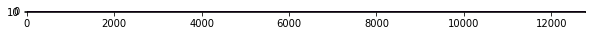

In [17]:
plt.imshow(Sxx_resized[:, 0]);

In [14]:
X_seasonal.shape

(12801, 41)

In [12]:
Sxx.shape

(17, 41, 12770)

In [100]:
Sxx[:, 0, 0]

array([2.30345769e-05, 3.20222291e-03, 6.30967680e-04, 9.42865103e-05,
       4.34554664e-05, 5.06664176e-06, 6.72567668e-05, 6.70077685e-06,
       2.11745408e-05, 3.15101170e-05, 1.56907679e-05, 2.39217437e-05,
       5.24528467e-07, 1.34942375e-05, 3.25980259e-05, 1.53004846e-05,
       1.50333276e-06])

In [95]:
@interact(component=(0, 40))
def spec_plot(component):
    plt.figure(figsize=(10, 10))
    plt.imshow(Sxx[:, component])

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

In [92]:
Sxx.shape

(17, 41, 12770)

In [41]:
seas_ft = fftn(X_seasonal, axes=0)

array([[  1.23573732+0.j        ,   1.588518  +0.j        ,
         -6.44147849+0.j        , ..., -12.40553047+0.j        ,
         -7.1484488 +0.j        ,  -5.6909314 +0.j        ],
       [  1.22648815+0.02314375j,   1.58541202+0.316872j  ,
         -6.45867291+0.01457022j, ..., -12.41383152-0.01902549j,
         -7.15294842-0.57270851j,  -5.6885082 +0.04292401j],
       [  1.19836428+0.04561675j,   1.57592163+0.6393423j ,
         -6.51096875+0.02840595j, ..., -12.4390653 -0.03956507j,
         -7.16660117-1.1552281j ,  -5.6811895 +0.0878923j ],
       ...,
       [  1.15019754-0.06669384j,   1.55951028-0.97339003j,
         -6.60057958-0.04070791j, ..., -12.48225956+0.06323416j,
         -7.18988527+1.75804362j,  -5.66882554-0.13710544j],
       [  1.19836428-0.04561675j,   1.57592163-0.6393423j ,
         -6.51096875-0.02840595j, ..., -12.4390653 +0.03956507j,
         -7.16660117+1.1552281j ,  -5.6811895 -0.0878923j ],
       [  1.22648815-0.02314375j,   1.58541202-0.316872j  

In [ ]:
X_seasonal = rolling_window(decomposed.seasonal, window_len)[:-prediction_len]
y_seasonal = rolling_window(decomposed.seasonal, prediction_len, window_len)

X_seas_tr, X_seas_te, y_seas_tr, y_seas_te = train_test_split(X_seasonal, y_seasonal, train_size=0.7, shuffle=False)

### Train/test

In [30]:
from src.models.torch.models import LSTM, Trainer
from src.models.torch.utils import to_dataloader, get_prev_states
import torch

seas_train_set = to_dataloader(X_seas_tr, y_seas_tr, dict(batch_size=batch_size))
seas_test_set = to_dataloader(X_seas_te, y_seas_te, dict(batch_size=batch_size))

### Обучение

In [9]:
config = dict(
    input_size=X_tr[0].shape[1],
    hidden_size=16,
    num_layers=1,
    batch_first=True,
    bidirectional=True,
)

seas_model = LSTM(**config).to(device)
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(seas_model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                       patience=3,
                                                       threshold=0.01)

trainer = Trainer(
    seas_model,
    criterion,
    optim,
    scheduler,
    device,
    get_log_path(
        f'logs/seas-{config["num_layers"]}-layers-{config["hidden_size"]}-hidden-{window_len}-len'
    ),
    stateful=True)

In [11]:
trainer.train(seas_train_set, seas_test_set, 10)

Epoch 0 of train: :   0%|                                                                                                                           | 0/280 [00:00<?, ?it/s, loss=0.701]D:\anomaly-detection\src\models\torch\utils.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 0 of train: :   1%|▊                                                                                                                   | 2/280 [00:00<00:17, 15.88it/s, loss=0.54]

Epoch 0/9
----------


Epoch 1 of train: :   1%|█▋                                                                                                                | 4/280 [00:00<00:07, 38.83it/s, loss=0.0903]

Loss: 0.0592

Epoch 1/9
----------


Epoch 2 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:10, 25.21it/s, loss=0.0722]

Loss: 0.0451

Epoch 2/9
----------


Epoch 3 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:11, 23.81it/s, loss=0.0288]

Loss: 0.0358

Epoch 3/9
----------


Epoch 4 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:11, 24.79it/s, loss=0.0242]

Loss: 0.0340

Epoch 4/9
----------


Epoch 5 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:11, 24.79it/s, loss=0.0173]

Loss: 0.0297

Epoch 5/9
----------


Epoch 6 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:10, 25.21it/s, loss=0.0137]

Loss: 0.0280

Epoch 6/9
----------


Epoch 7 of train: :   1%|█▏                                                                                                               | 3/280 [00:00<00:10, 25.42it/s, loss=0.00634]

Loss: 0.0304

Epoch 7/9
----------


Epoch 8 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:12, 22.73it/s, loss=0.0136]

Loss: 0.0273

Epoch 8/9
----------


Epoch 9 of train: :   1%|█▏                                                                                                                | 3/280 [00:00<00:12, 21.74it/s, loss=0.0165]

Loss: 0.0311

Epoch 9/9
----------


Epoch 9 of val: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.62it/s, loss=0.231]


Loss: 0.0295

